## The Script
For the evaluation of the segmentation metrics is highly based on the helper functions provided by Janesick et al. so we placed it in `Xenium Segmentation Transfer/segmentation-comparison.ipynb` 
Some remarks on the evaluation can be found below:


## ENACT vs Xenium
Are the two segmentations we compare. Bin2cell as well as Spaceranger v4.0 both rely on stardist nucleus segmentation and subsequent circular expansion so I assume they would be similar enough. This neglects the following violations: 
- This assumption does not hold true for bin2cell as it also relies on the Total Gene Expression (GEX) image for segmentation.
- Also for Spaceranger it is not fully valid as 10X claims to have fine-tuned their stardist model so the nucleus segmentation could be slightly varying wrt. the public models.


Here we show the rlation between bins under the segmentation (proxy for cell area) and transcript count per cell.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scanpy as sc
from PIL import Image
import tifffile as tifi
from IPython.display import IFrame
from datetime import datetime
import os
from shapely import wkt

In [30]:
cells_enact_path = "/srv/gstore/projects/p37785/EzPyzENACTApp_2025-06-29--17-57-49/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"
cells_xseg_path = "/srv/gstore/projects/p1001/EzPyzENACTApp_2025-06-02--15-53-26/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2/chunks/weighted_by_area/celltypist_results/cells_adata.h5"


In [26]:
# Loading Anndata object
adata_cells_enact = sc.read_h5ad(cells_enact_path)
adata_cells_xseg = sc.read_h5ad(cells_xseg_path)

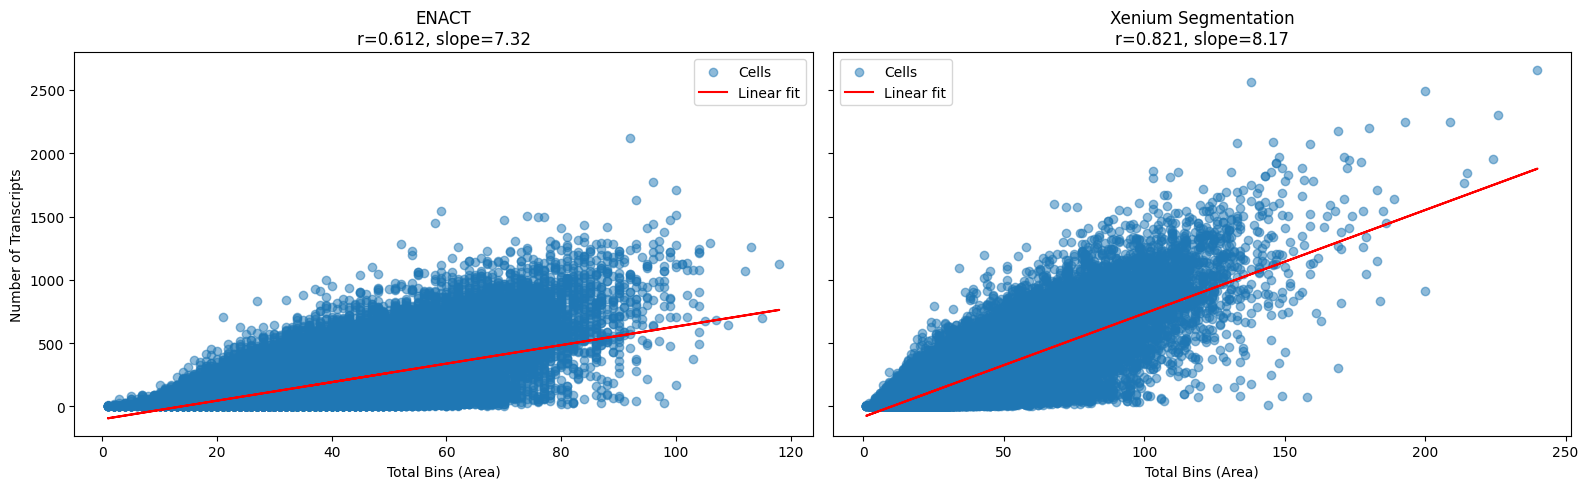

In [27]:
# Extract stats DataFrame for both datasets
stats_enact = adata_cells_enact.obsm["stats"].copy()
stats_vpx = adata_cells_xseg.obsm["stats"].copy()

# Calculate total bins for each cell
stats_enact["total_bins"] = stats_enact["num_shared_bins"] + stats_enact["num_unique_bins"]
stats_vpx["total_bins"] = stats_vpx["num_shared_bins"] + stats_vpx["num_unique_bins"]

# Calculate correlations and fits
corr_enact = stats_enact["total_bins"].corr(stats_enact["num_transcripts"])
fit_enact = np.polyfit(stats_enact["total_bins"], stats_enact["num_transcripts"], 1)
fit_fn_enact = np.poly1d(fit_enact)

corr_vpx = stats_vpx["total_bins"].corr(stats_vpx["num_transcripts"])
fit_vpx = np.polyfit(stats_vpx["total_bins"], stats_vpx["num_transcripts"], 1)
fit_fn_vpx = np.poly1d(fit_vpx)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# ENACT plot
axes[0].scatter(stats_enact["total_bins"], stats_enact["num_transcripts"], alpha=0.5, label="Cells")
axes[0].plot(stats_enact["total_bins"], fit_fn_enact(stats_enact["total_bins"]), color="red", label="Linear fit")
axes[0].set_xlabel("Total Bins (Area)")
axes[0].set_ylabel("Number of Transcripts")
axes[0].set_title(f"ENACT\nr={corr_enact:.3f}, slope={fit_enact[0]:.2f}")
axes[0].legend()

# VPX plot
axes[1].scatter(stats_vpx["total_bins"], stats_vpx["num_transcripts"], alpha=0.5, label="Cells")
axes[1].plot(stats_vpx["total_bins"], fit_fn_vpx(stats_vpx["total_bins"]), color="red", label="Linear fit")
axes[1].set_xlabel("Total Bins (Area)")
axes[1].set_title(f"Xenium Segmentation\nr={corr_vpx:.3f}, slope={fit_vpx[0]:.2f}")
axes[1].legend()

plt.tight_layout()
plt.show()

Note: the sloep is higher than the average transcript per 2um x 2um bin value which is 4.4
(see https://cf.10xgenomics.com/samples/spatial-exp/3.0.0/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2/Visium_HD_Human_Lung_Cancer_post_Xenium_Prime_5K_Experiment2_web_summary.html)

In [28]:
caption = (
    "Scatter plots showing the relationship between cell area (total bins) and number of transcripts per cell for ENACT (left) and Xenium Segmentation (right). "
    "Each point represents a cell. The red line indicates the linear fit, with Pearson correlation coefficient (r) and slope shown in the titles."
)
print(caption)

Scatter plots showing the relationship between cell area (total bins) and number of transcripts per cell for ENACT (left) and Xenium Segmentation (right). Each point represents a cell. The red line indicates the linear fit, with Pearson correlation coefficient (r) and slope shown in the titles.
